# Use Keras and hyperparameter optimization (HPO) to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook contains steps and code to demonstrate support of Deep Learning experiments in the Watson Machine Learning service. It introduces commands for data retrieval, training definition persistance, experiment training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.7.


## Learning goals

The learning goals of this notebook are:

-  Working with the Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of the trained model.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Create model definition](#model_df)
3.	[Train model](#training)
4.  [Persist trained model](#persist)
5.	[Deploy and Score](#deploy)
6.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install ibm-watson-machine-learning

In [4]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [7]:
client.set.default_space(space_id)

'SUCCESS'

### 1.1 Working with Cloud Object Storage

-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "***",
            "secret_access_key": "***"
       }
    ```

The `ibm_boto3` library allows Python developers to manage Cloud Object Storage.

**Note:** If `ibm_boto3` is not preinstalled in you environment please install it by running the following command: `!pip install ibm-cos-sdk`

In [8]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
warnings.filterwarnings('ignore')

**Action**: Enter your COS credentials in the following cell.  
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.  
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [9]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "***",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "***",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

Create the Boto resource by providing type, endpoint_url and credentials.

In [11]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create the buckets that you will use to store training data and training results.

**Note:**: Bucket name has to be unique - please update following ones to any unique name.

In [13]:
buckets = ['tf-keras-data-example', 'tf-keras-results-example']
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

The buckets are created.

In [ ]:
print(list(cos.buckets.limit(50)))

### 1.2 Download the MNIST data and upload it to the COS bucket

In this notebook we work with the Keras **MNIST** sample dataset. Download the training data and upload them to 'mnist-keras-data' bucket.

Following cell creates the 'MNIST_KERAS_DATA' folder and downloads the file from link.

**Note:** First install `wget` library by the following command
`!pip install wget`

In [14]:
link = 'https://s3.amazonaws.com/img-datasets/mnist.npz'

In [15]:
import wget

data_dir = 'MNIST_KERAS_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  
        
!ls MNIST_KERAS_DATA

mnist.npz


Upload the data files to created bucket.

In [16]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

mnist.npz is uploaded.


You can see the list of all buckets and their contents.

In [ ]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

### 1.3 Create connections to a COS bucket.

In [13]:
datasource_type = client.connections.get_datasource_type_uid_by_name('bluemixcloudobjectstorage')

input_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: "Input COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[0],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

output_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Output COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[1],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

input_conn_details = client.connections.create(meta_props=input_conn_meta_props)
output_conn_details = client.connections.create(meta_props=output_conn_meta_props)

Creating connections...
SUCCESS
Creating connections...
SUCCESS


In [14]:
input_connection_id = client.connections.get_uid(input_conn_details)
output_connection_id = client.connections.get_uid(output_conn_details)

The model is ready to be trained.

<a id="model_def"></a>
# 2. Create model definition

For the purpose of this example two Keras model definitions have been prepared:

 - Multilayer Perceptron (MLP)
 - Convolution Neural Network (CNN)

### 2.1 Prepare model definition metadata

In [17]:
metaprops = {
    client.model_definitions.ConfigurationMetaNames.NAME: "MNIST mlp model definition",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "MNIST mlp model definition",
    client.model_definitions.ConfigurationMetaNames.COMMAND: "python3 mnist_mlp.py",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.7"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

### 2.2 Get sample model definition content files from git (Python scripts with CNN and MLP)

In [18]:
filename_mnist = 'MNIST.zip'

if not os.path.isfile(filename_mnist):
    filename_mnist = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/definitions/keras/mnist/MNIST.zip')

**Tip**: Convert below cell to code and run it to see model deinition's code.

### 2.3 Publish model definition

In [19]:
model_definition_details = client.model_definitions.store(filename_mnist, meta_props=metaprops)

In [20]:
model_definition_id = client.model_definitions.get_id(model_definition_details)
print(model_definition_id)

2c2f7550-ae9e-4f04-bcb0-8e19a30550b0


#### List model definitions

In [ ]:
client.model_definitions.list(limit=5)

<a id="training"></a>
# 3. Train model

### 3.1 Prepare training metadata

In [21]:
training_metadata = {
    client.training.ConfigurationMetaNames.NAME: "Keras-MNIST",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "Keras-MNIST predict written digits",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "MNIST",
      "description": "predict written difits"
    }],
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
    "name": "MNIST results",
    "connection": {
        "id": output_connection_id,
    },
    "location": {
        "bucket": buckets[1],
        "file_name": "."
    },
    "type": "connection_asset"
  },
  client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_id,
        "hardware_spec": {
          "name": "K80",
          "nodes": 1
        },
        "software_spec": {
          "name": "tensorflow_2.4-py3.7"
        },
        "parameters": {
          "name": "MNIST mlp",
          "description": "Simple MNIST mlp model"
        }
      },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
       {
      "name": "training_input_data",
      "type": "connection_asset",
      "connection": {
          "id": input_connection_id,
      },
      "location": {
        "bucket": buckets[0],
        "file_name": "."
      },
      "schema": {
        "id":"idmlp_schema",
        "fields": [
          {
            "name": "text",
            "type": "string"
          }
        ]
      }
    }
  ]
}

### 3.2 Train model in background

In [22]:
training = client.training.run(training_metadata)

### 3.3 Get training id and status

In [23]:
training_id = client.training.get_uid(training)

In [26]:
client.training.get_status(training_id)["state"]

'completed'

### 3.4 Get training details

In [ ]:
training_details = client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

#### List trainings

In [ ]:
client.training.list(limit=5)

#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to delete train runs and results add `hard_delete=True` as a parameter.

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Download trained model from COS

In [28]:
uid = client.training.get_details(training_id)['entity']['results_reference']['location']['logs']

#### Download model from COS

In [29]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

model_path = ""
for obj in bucket_obj.objects.iterator():
    if uid in obj.key and obj.key.endswith(".h5"):
        model_path = obj.key
        break

model_name = model_path.split("/")[-1]
bucket_obj.download_file(model_path, model_name)

#### Load downloaded_model.
**Hint**: To install tensorflow execute `!pip install tensorflow`

In [30]:
from tensorflow import keras

model = keras.models.load_model(model_name)

### 4.2 Publish model

To specify format how keras model is saved use parameter:
```
model_meta_props = {
    ...
    client.repository.ModelMetaNames.TF_MODEL_PARAMS: {"save_format": "tf"}
    ...
}
```
Where `tf` stands for standard tensorflow format and `h5` will save a model in HDF format.  
For keras models `h5` is default and for native tensorflow models `tf` is used if `TF_MODEL_PARAMS` not passed.

### 4.2 Publish model

In [31]:
software_spec_uid = client.software_specifications.get_uid_by_name('default_py3.7_opence')

In [33]:
model_meta_props = {
    client.repository.ModelMetaNames.NAME: "Keras MNIST",
    client.repository.ModelMetaNames.TYPE: "tensorflow_2.4",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TF_MODEL_PARAMS: {"save_format": "h5"}
}

published_model = client.repository.store_model(model=model, meta_props=model_meta_props)
model_uid = client.repository.get_model_uid(published_model)

### 4.3 Get model details

In [34]:
model_details = client.repository.get_details(model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "e4429883-c883-42b6-87a8-f419d64088cd",
      "name": "default_py3.7"
    },
    "type": "tensorflow_2.1"
  },
  "metadata": {
    "created_at": "2021-02-02T11:19:14.711Z",
    "id": "938066be-0bc2-417d-8788-bff7e106eb37",
    "modified_at": "2021-02-02T11:19:23.975Z",
    "name": "Keras MNIST",
    "owner": "IBMid-55000091VC",
    "space_id": "d70a423e-bab5-4b24-943a-3b0b29ad7527"
  },
  "system": {
    "warnings": []
  }
}


#### List stored models

In [ ]:
client.repository.list_models(limit=5)

<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Create online deployment for published model

In [35]:
deployment = client.deployments.create(model_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME: "Keras MNIST",
                                            client.deployments.ConfigurationMetaNames.ONLINE: {}})

deployment_uid = client.deployments.get_uid(deployment)



#######################################################################################

Synchronous deployment creation for uid: '938066be-0bc2-417d-8788-bff7e106eb37' started

#######################################################################################


initializing..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='25b0e0c5-b395-4794-a037-e2ced244cf55'
------------------------------------------------------------------------------------------------




### 5.2 Get deployments details

In [36]:
deployments_details = client.deployments.get_details(deployment_uid)
print(json.dumps(deployments_details, indent=2))

{
  "entity": {
    "asset": {
      "id": "938066be-0bc2-417d-8788-bff7e106eb37"
    },
    "custom": {},
    "deployed_asset_type": "model",
    "hardware_spec": {
      "id": "Not_Applicable",
      "name": "XS",
      "num_nodes": 1
    },
    "name": "Keras MNIST",
    "online": {},
    "space_id": "d70a423e-bab5-4b24-943a-3b0b29ad7527",
    "status": {
      "online_url": {
        "url": "https://yp-qa.ml.cloud.ibm.com/ml/v4/deployments/25b0e0c5-b395-4794-a037-e2ced244cf55/predictions"
      },
      "state": "ready"
    }
  },
  "metadata": {
    "created_at": "2021-02-02T11:19:27.842Z",
    "id": "25b0e0c5-b395-4794-a037-e2ced244cf55",
    "modified_at": "2021-02-02T11:19:27.842Z",
    "name": "Keras MNIST",
    "owner": "IBMid-55000091VC",
    "space_id": "d70a423e-bab5-4b24-943a-3b0b29ad7527"
  }
}


#### List deployments

In [ ]:
client.deployments.list(limit=5)

### 5.3 Score deployed model

Let's plot two digits. **Action:** Please install `matplotlib`, `numpy`

In [37]:
import numpy as np

dataset_filename='mnist.npz'
mnist_dataset = np.load(os.path.join(data_dir, dataset_filename))
x_test = mnist_dataset['x_test']

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

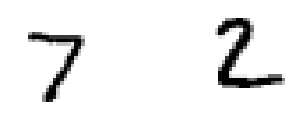

In [39]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Our input node expects to get data with shape (784,) so we need to reshape our two digits.

In [40]:
image_1 = x_test[0].ravel() / 255
image_2 = x_test[1].ravel() / 255

#### Prepare scoring payload and score.

In [41]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1.tolist(), image_2.tolist()]}
    ]
}
scores = client.deployments.score(deployment_uid, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "id": "dense_2",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            7.466905316277916e-08,
            9.893429705698509e-06,
            3.900993033312261e-05,
            4.162672848906368e-05,
            8.139633411730074e-10,
            1.8486717863197555e-06,
            9.200988582147573e-11,
            0.9999065399169922,
            3.4652100566745503e-07,
            6.348946044454351e-07
          ],
          7,
          [
            7.466905316277916e-08,
            9.893429705698509e-06,
            3.900993033312261e-05,
            4.162672848906368e-05,
            8.139633411730074e-10,
            1.8486717863197555e-06,
            9.200988582147573e-11,
            0.9999065399169922,
            3.4652100566745503e-07,
            6.348946044454351e-07
          ]
        ],
        [
          [
            1.

<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to run experiments. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=analytics)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020, 2021 IBM. This notebook and its source code are released under the terms of the MIT License.